## Summary

----

## Imports

In [1]:
import math
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch
from scipy import stats

In [2]:
%matplotlib inline

## Parameters

In [3]:
NOTEBOOK_NAME = "07_protein_analysis_figures"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME)
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('07_protein_analysis_figures')

In [4]:
METHOD = "raw.scan"

MUTATION_METHOD = METHOD
STABILITY_METHOD = METHOD

## Functions

In [5]:
def add_diff(df, colname):
    if f"{colname}_wt" not in df:
        before_ = len(df)
        ext = ".pdb" if not df.iloc[0]["name"].endswith(".pdb") else ""
        row_is_wt = (df["name"] + ext) == df["my_wt"]
        assert set(df[row_is_wt]["my_wt"]) == set(df["my_wt"])
        df2 = df[row_is_wt][["my_wt", colname]].rename(columns={colname: f"{colname}_wt"})
        df = df.merge(df2, on="my_wt")
        assert before_ == len(df), (before_, len(df))
    df[f"{colname}_change"] = df[f"{colname}"] - df[f"{colname}_wt"]
    return df

In [6]:
def get_conf_interval(r, num):
    stderr = 1.0 / math.sqrt(num - 3)
    delta = 1.96 * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return r - lower, upper - r 

## Load data

### Protherm

### GAPF - Mutations

In [7]:
stability_scores_for_mutations = torch.load(
    NOTEBOOK_PATH.parent.joinpath(
        "06_global_analysis_of_protein_folding", f"stability_scores_for_mutations.{METHOD}.torch"
    )
)

In [8]:
stability_scores_for_mutations["ssm2"]

,name,sequence,my_wt,pos,mut,wt_aa,ec50_t,delta_ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,...,ec50_pred_c,delta_pred_vs_wt_c,ec50_rise_c,stabilityscore_c,ec50_rise_c_adj,stabilityscore_c_adj,consensus_ec50_rise,consensus_stability_score,library_name,network_score
0,EEHEE_rd3_0037.pdb,TTIKVNGQEYTVPLSPEQAAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,0,na,wt,4.67,0.00,4.7,4.7,...,0.51,0.00,2.83,0.85,2.83,0.85,2.83,0.85,ssm2,119.307373
1,EEHEE_rd3_0037.pdb_A19D,TTIKVNGQEYTVPLSPEQDAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,D,A,-0.40,-5.07,-0.5,-0.3,...,0.81,0.30,1.00,0.30,1.00,0.30,0.99,0.30,ssm2,100.146294
2,EEHEE_rd3_0037.pdb_A19E,TTIKVNGQEYTVPLSPEQEAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,E,A,-0.32,-4.99,-0.4,-0.2,...,0.73,0.22,0.76,0.23,0.76,0.23,0.76,0.23,ssm2,101.972137
3,EEHEE_rd3_0037.pdb_A19F,TTIKVNGQEYTVPLSPEQFAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,F,A,1.72,-2.95,1.7,1.8,...,0.13,-0.37,1.75,0.53,1.75,0.53,1.83,0.55,ssm2,94.405151
4,EEHEE_rd3_0037.pdb_A19G,TTIKVNGQEYTVPLSPEQGAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,G,A,1.85,-2.82,1.8,2.2,...,0.62,0.12,1.84,0.55,1.84,0.55,1.77,0.53,ssm2,113.760933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12846,villin_W23R,GSSGSLSDEDFKAVFGMTRSAFANLPLRKQQNLKKEKGLFGSS,villin,23,R,W,1.69,-2.36,1.6,1.8,...,-1.20,-0.11,2.31,0.70,2.31,0.70,2.57,0.77,ssm2,89.534210
12847,villin_W23S,GSSGSLSDEDFKAVFGMTRSAFANLPLSKQQNLKKEKGLFGSS,villin,23,S,W,2.65,-1.40,2.6,2.7,...,-0.94,0.15,2.63,0.79,2.63,0.79,2.72,0.82,ssm2,90.937111
12848,villin_W23T,GSSGSLSDEDFKAVFGMTRSAFANLPLTKQQNLKKEKGLFGSS,villin,23,T,W,2.43,-1.62,2.2,2.6,...,-0.89,0.20,2.67,0.80,2.67,0.80,2.63,0.79,ssm2,90.866333
12849,villin_W23V,GSSGSLSDEDFKAVFGMTRSAFANLPLVKQQNLKKEKGLFGSS,villin,23,V,W,2.05,-2.00,1.9,2.2,...,-1.00,0.09,2.62,0.79,2.62,0.79,2.57,0.77,ssm2,90.731514


#### Format `ssm2`

In [9]:
stability_scores_for_mutations["ssm2"]["consensus_stability_score2"] = (
    stability_scores_for_mutations["ssm2"]["stabilityscore_t"]
    + stability_scores_for_mutations["ssm2"]["stabilityscore_c"]
) / 2

In [10]:
for column in [
    "network_score",
    "stabilityscore_t",
    "stabilityscore_c",
    "consensus_stability_score",
    "consensus_stability_score2",
]:
    stability_scores_for_mutations["ssm2"] = add_diff(stability_scores_for_mutations["ssm2"], column)

#### Format `fig1`

In [11]:
stability_scores_for_mutations["fig1"] = stability_scores_for_mutations["fig1"].rename(
    columns={"deltaGunf thermal": "dg_thermal", "deltaGunf chemical": "dg_chemical"}
)

stability_scores_for_mutations["fig1"]["consensus_stability_score"] = (
    stability_scores_for_mutations["fig1"]["stabilityscore_t"]
    + stability_scores_for_mutations["fig1"]["stabilityscore_c"]
) / 2

stability_scores_for_mutations["fig1"]["consensus_dg"] = (
    stability_scores_for_mutations["fig1"]["dg_thermal"] + stability_scores_for_mutations["fig1"]["dg_chemical"]
) / 2

In [12]:
for column in [
    "network_score",
    "stabilityscore_t",
    "stabilityscore_c",
    "consensus_stability_score",
    "dg_thermal",
    "dg_chemical",
    "consensus_dg",
    "Tm",
]:
    stability_scores_for_mutations["fig1"] = add_diff(stability_scores_for_mutations["fig1"], column)

### GAPF - Stability

In [13]:
stability_scores_for_designs = torch.load(
    NOTEBOOK_PATH.parent.joinpath(
        "06_global_analysis_of_protein_folding", f"stability_scores_for_selections.{METHOD}.torch"
    )
)

## Figures

### Protherm

### GAPF - Mutations

In [14]:
x_col = "network_score_change"
y_col = "consensus_stability_score_change"
library = "ssm2"

correlations = []

for my_wt, gp in stability_scores_for_mutations[library].groupby("my_wt"):
    x = gp[[x_col, y_col]].dropna()
    if x.empty:
        print(f"Skipping {my_wt}!")
        continue
    corr = stats.spearmanr(x[x_col], x[y_col])
    corr_conf = get_conf_interval(corr[0], len(x))
    correlations.append(
        {
            "my_wt": my_wt,
            "corr": corr[0],
            "pvalue": corr[1],
            "corr_lower_bound": corr_conf[0],
            "corr_upper_bound": corr_conf[1],
        }
    )
correlations_df = pd.DataFrame(correlations, columns=correlations[0].keys())

Skipping EHEE_0882.pdb!
Skipping EHEE_rd2_0005.pdb!
Skipping EHEE_rd3_0015.pdb!
Skipping HHH_0142.pdb!


In [15]:
correlations_df

,my_wt,corr,pvalue,corr_lower_bound,corr_upper_bound
0,EEHEE_rd3_0037.pdb,0.394147,3.306064e-30,0.061183,0.057878
1,EEHEE_rd3_1498.pdb,0.393333,4.440973e-30,0.061226,0.057925
2,EEHEE_rd3_1702.pdb,0.149497,2.932858e-05,0.069584,0.068134
3,EEHEE_rd3_1716.pdb,0.434199,5.645419e-37,0.058951,0.055452
4,HEEH_rd2_0779.pdb,0.480017,6.493175e-46,0.056094,0.052426
5,HEEH_rd3_0223.pdb,0.393417,4.307661e-30,0.061221,0.057920
6,HEEH_rd3_0726.pdb,0.256082,4.534633e-13,0.067015,0.064641
7,HEEH_rd3_0872.pdb,0.237012,2.342070e-11,0.067597,0.065378
8,HHH_rd2_0134.pdb,0.295338,4.596301e-17,0.065648,0.062973
9,HHH_rd3_0138.pdb,0.429652,3.688339e-36,0.059216,0.055738


In [16]:
def to_name(s):
    s = s.replace(".pdb", "")
    if "_" in s:
        s1, s2 = s.split("_", 1)
        s2 = s2.replace("_", "-")
        return s1, f"{s2:>9s}"
    else:
        return "Known", f"{s:>9s}"


df = correlations_df.copy()
df["group"], df["name"] = list(zip(*df["my_wt"].apply(to_name).values))
df = df.sort_values("my_wt", ascending=False)

df

,my_wt,corr,pvalue,corr_lower_bound,corr_upper_bound,group,name
12,villin,0.533106,1.275038e-47,0.058296,0.053639,Known,villin
11,hYAP65,0.442019,5.715900e-41,0.056488,0.053187,Known,hYAP65
10,Pin1,0.434542,9.606567e-34,0.061974,0.058115,Known,Pin1
9,HHH_rd3_0138.pdb,0.429652,3.688339e-36,0.059216,0.055738,HHH,rd3-0138
8,HHH_rd2_0134.pdb,0.295338,4.596301e-17,0.065648,0.062973,HHH,rd2-0134
7,HEEH_rd3_0872.pdb,0.237012,2.342070e-11,0.067597,0.065378,HEEH,rd3-0872
6,HEEH_rd3_0726.pdb,0.256082,4.534633e-13,0.067015,0.064641,HEEH,rd3-0726
5,HEEH_rd3_0223.pdb,0.393417,4.307661e-30,0.061221,0.057920,HEEH,rd3-0223
4,HEEH_rd2_0779.pdb,0.480017,6.493175e-46,0.056094,0.052426,HEEH,rd2-0779
3,EEHEE_rd3_1716.pdb,0.434199,5.645419e-37,0.058951,0.055452,EEHEE,rd3-1716


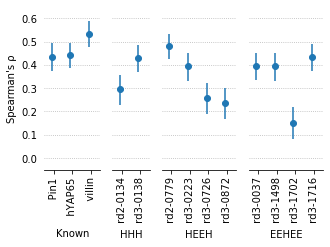

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(5, 3), gridspec_kw={'width_ratios': [3, 2, 4, 4]})

for i, (group, gp) in enumerate(sorted(df.groupby("group"), key=lambda t: t[0], reverse=True)):
    ax = axs[i]

    gp = gp.sort_values("name")

    x = np.arange(len(gp))  # the label locations
    width = 0.2  # the width of the bars

    rects1 = ax.errorbar(
        x - width / 2,
        gp["corr"].values,
        fmt="o",
        #         width,
        yerr=gp[["corr_lower_bound", "corr_upper_bound"]].values.T,
        label="ProteinSolver",
    )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylim(-0.05, 0.65)
    #     ax.set_title("Scores by group and gender")
    
    ax.set_xticks(x)
    ax.set_xticklabels(gp["name"].values, rotation="vertical")
    ax.set_xlabel(group)
    ax.set_xlim(x[0] - 0.5, x[-1] + 0.5)
    if i == 0:
        ax.set_ylabel("Spearman's ρ")

    if i > 0:
        ax.set_yticklabels("")

    for tic in ax.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    #     ax.spines['bottom'].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.grid(axis="y", linestyle=":")

### GAPF - Stability

In [18]:
correlations = []

for library in ["rd1", "rd2", "rd3", "rd4"]:
    df = (
        stability_scores_for_designs[library]
        .dropna(
            subset=[
                "network_score",
                "talaris2013_score",
                "betanov15_score",
                "domain",
                "stabilityscore_t",
                "stabilityscore_c",
            ]
        )
        .copy()
    )
    #     df["domain"] = df["name"].str.split("_").str[0]
    for domain, gp in df.groupby("domain"):
        for score in ["network_score", "talaris2013_score", "betanov15_score"]:
            corr_t = stats.spearmanr(gp[score] / gp["sequence_length"], gp["stabilityscore_t"])
            corr_c = stats.spearmanr(gp[score] / gp["sequence_length"], gp["stabilityscore_c"])
            corr = stats.spearmanr(
                gp[score] / gp["sequence_length"], gp[["stabilityscore_t", "stabilityscore_c"]].mean(axis=1)
            )
            corr_conf = get_conf_interval(corr[0], len(gp[score]))
            correlations.append(
                (
                    library,
                    domain,
                    score,
                    corr_t[0],
                    corr_t[1],
                    corr_c[0],
                    corr_c[1],
                    corr[0],
                    corr[1],
                    corr_conf[0],
                    corr_conf[1],
                )
            )

correlations_df = pd.DataFrame(
    correlations,
    columns=[
        "library",
        "domain",
        "feature",
        "corr_t",
        "pvalue_t",
        "corr_c",
        "pvalue_c",
        "corr",
        "pvalue",
        "corr_conf_lower",
        "corr_conf_upper",
    ],
)

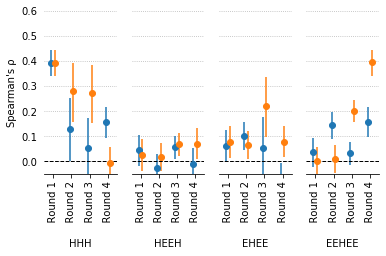

In [25]:
fig, axs = plt.subplots(1, 4, figsize=(6, 3))

for i, (domain, gp) in enumerate(sorted(correlations_df.groupby("domain"), key=lambda x: x[0], reverse=True)):
    ax = axs[i]

    gp = gp.sort_values(["domain", "library"])

    x = np.arange(4)  # the label locations
    width = 0.2  # the width of the bars

    df = gp[gp["feature"] == "network_score"]
    rects1 = ax.errorbar(
        x - width / 2,
        df["corr"].values,
        fmt="o",
        #         width,
        yerr=df[["corr_conf_lower", "corr_conf_upper"]].values.T,
        label="ProteinSolver",
    )

    df = gp[gp["feature"] == "betanov15_score"]
    rects2 = ax.errorbar(
        x + width / 2,
        -df["corr"].values,
        fmt="o",
        #         width,
        yerr=-df[["corr_conf_lower", "corr_conf_upper"]].values.T,
        label="Rosetta beta_nov",
    )

    ax.hlines(0, x[0] - 0.5, x[-1] + 0.5, linestyles="--", linewidth=1)

    ax.set_xticks(x)
    ax.set_xticklabels([f"{'Round':>9s} {i}" for i in range(1, 5)], rotation="vertical")
    ax.set_xlabel(domain)
    ax.set_xlim(x[0] - 0.5, x[-1] + 0.5)

    if i == 0:
        ax.set_ylabel("Spearman's ρ")
    if i > 0:
        ax.set_yticklabels("")
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)
    ax.set_ylim(-0.05, 0.6)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.grid(axis="y", linestyle=":")

## 